<a href="https://colab.research.google.com/github/BedinEduardo/Colab_Repositories/blob/master/PyTorch_Spatial_Transformer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Transformer Network Tutorial

In this tutorial, will learn how to augment your NN using a visual attention mechanism called spatial transformer network.

Spatial transformer network are a generalization of differentiable attention to any spatial transformation. Spatial transformer networks (STN) allow a NN to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model. For example, it can crop a region of interest, scale and correct the orientation of an image. I can be a useful mechanism because CNNs are not invariant to rotation and scale and more general affine transformations.

One the best things about STN is the ability to simply plug it into any existing CNN with very little modification.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
plt.ion()  # interactive mode

## Loading the data

In this post we experiment with the classic MNIST dataset. Using standard CNN augmented with a spatial transformer NN.

In [ ]:
from six.moves import urllib

In [ ]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent','Monzila/5')]
urllib.request.install_opener(opener)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081))
                   ])), batch_size=64, shuffle=True, num_workers=4)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.70MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4
)

## Depcting Spatial transformer networks

Spatial transformer network boils down to three main components.

* The localization network is a regular CNN which regress the transformation parameters. The transformation is never learned explicity from this dataset, instead the network learns automatically the spatial transformations that enhances the global accuracy.
* The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
* The sampler uses the parameters of the transformation and applies it to the input image.

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1,10, kernel_size=5)
    self.conv2 = nn.Conv2d(10,20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50,10)

    # Spatial transformer localization-network
    self.localization = nn.Sequential(
        nn.Conv2d(1,8, kernel_size=7),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        nn.Conv2d(8,10, kernel_size=5),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True)
    )

    # Regressor for the 3 * 2 affine matrix
    self.fc_loc = nn.Sequential(
        nn.Linear(10*3*3,32),
        nn.ReLU(True),
        nn.Linear(32, 3*2)
    )

    # Initalize the weights/bias with identity transformation
    self.fc_loc[2].weight.data.zero_()
    self.fc_loc[2].bias.data.copy_(torch.tensor([1,0,0,0,1,0], dtype=torch.float))

  # Spatial transformer network forward function
  def stn(self, x):
    xs = self.localization(x)
    xs = xs.view(-1,10 *3 * 3)
    theta = self.fc_loc(xs)
    theta = theta.view(-1,2,3)

    grid = F.affine_grid(theta, x.size())
    x = F.grid_sample(x, grid)

    return x

  def forward(self, x):
    # transfrorm the input
    x = self.stn(x)

    # Peform the usual forward pass
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)


In [ ]:
model = Net().to(device)

In [ ]:
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)


## Training the model

Now let's use the SGD algorithm to train the model..
The NN is learning the classification task in a supervised way.
In the same time the model is learning the STN (Spatial Transformer Network) automatically in an end-to-end fashion.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 500 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test():
  with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)

      # sum up batch loss
      test_loss += F.nll_loss(output, target, size_average=False).item()
      # get the index of the max log-probability
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

## Vizualizing the STN results

In [ ]:
def convert_image_np(inp):
  """
  Convert a Tensor to numpy image
  """
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0,1)

  return inp

In [ ]:
def visualize_stn():
  with torch.no_grad():
    # get a batch of training data
    data = next(iter(test_loader))[0].to(device)

    input_tensor = data.cpu()
    transformed_input_tensor = model.stn(data).cpu()

    in_grid = convert_image_np(
        torchvision.utils.make_grid(input_tensor))

    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))

    # plot the results side-by-side
    f, axarr  =plt.subplots(1,2)
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images')

    axarr[1].imshow(out_grid)
    axarr[1].set_title('Transformed Images')

In [ ]:
for epoch in range(1, 20+1):
  train(epoch)
  test()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5082: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desir

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305889
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.918069


/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2214, Accuracy: 9393/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.584301
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.255972

Test set: Average loss: 0.1176, Accuracy: 9639/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.343236
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.271164

Test set: Average loss: 0.1326, Accuracy: 9604/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.198799
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.145184

Test set: Average loss: 0.0776, Accuracy: 9762/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.359420
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.414727

Test set: Average loss: 0.0717, Accuracy: 9779/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.338487
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.281650

Test set: Average loss: 0.0675, Accuracy: 9800/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.182045
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.219642

Test set: Average loss: 0.0634, Accuracy: 9802/10000 (98%)

Tra

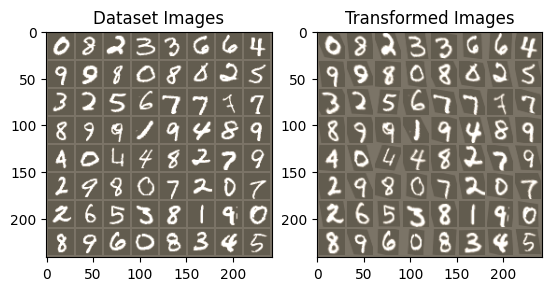

In [ ]:
# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()